## **Time to get your hands dirty! Supernova distances and redshifts (part 1)**

Measuring the cosmological relationship between **distance and redshift** is at the heart of the entire field of cosmology and allowed, among other things, the **discovery of dark energy**! 

At high redshifts, this is done with **Type Ia Supernovae**, which are standard (or better, *standardizable*) candles.

Let's recall the definition of **magnitude** and the **distance modulus** (ah! the astronomers...):

$$
\mu = m - M = 5 \log_{10}\left(\frac{d_L}{\text{pc}}\right) - 5
$$

Here is the **Hubble diagram** for Type Ia supernovae (which are standard candles). 

The lines show the predictions for cosmologies with varying amounts of $\Omega_m$ and $\Omega_\Lambda$.

The observed points all lie **above the line** for a universe with zero $\Lambda$.

The **lower panel**, with the slope caused by the inverse square law taken out, shows the difference between the predictions more clearly and explains why a model with $\Omega_\Lambda > 0$ is favored.

### Tasks
- First, explore fitting this data with the tecniques we have seen.
- Start from linear regression and polynomial regression
- For the case of polynomial regression, just fit many of them for now.
- Let's bet based on intuition! Which fit is the best?
- In what cases are you underfitting the data?
- In what cases are you overfitting the data?
- Now split the data into training and validation sets
- Implement a cross-validation procedure
- Pick the best!
- Does it agree with our bets?


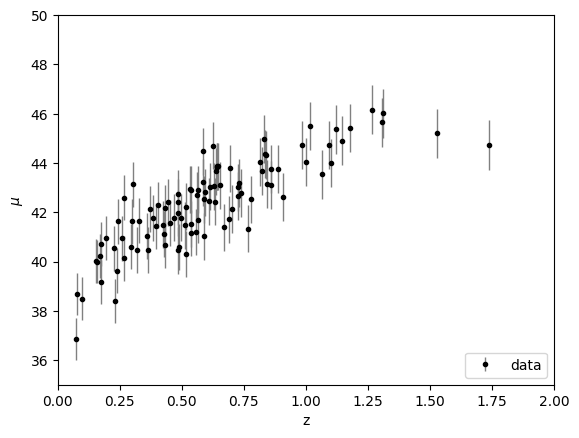

In [88]:
import numpy as np
import pylab as plt
from astroML.datasets import generate_mu_z

z_sample, mu_sample, dmu = generate_mu_z(100, random_state=1234)

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.xlabel("z")
plt.ylabel(r"$\mu$")
plt.legend(loc='lower right')
plt.xlim(0,2)
plt.ylim(35,50)
plt.show()

### Linear regression


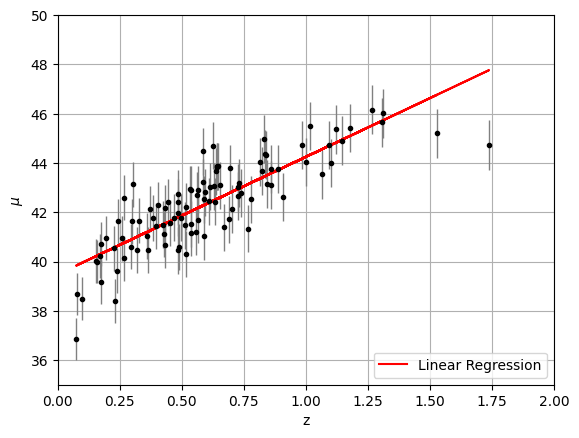

In [89]:
from astroML.linear_model import LinearRegression   # WITH ASTROML

model = LinearRegression()
model.fit(z_sample[:,np.newaxis], mu_sample, dmu) # [: , np.newaxis] reshapes z_sample to a 2D array
mu_fit = model.predict(z_sample[:,np.newaxis])

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1)
plt.plot(z_sample, mu_fit, '-r',label='Linear Regression')
plt.xlabel("z")
plt.ylabel(r"$\mu$")
plt.legend(loc='lower right')
plt.xlim(0,2)
plt.ylim(35,50)
plt.grid(True)
plt.show()

### Polynomial regression

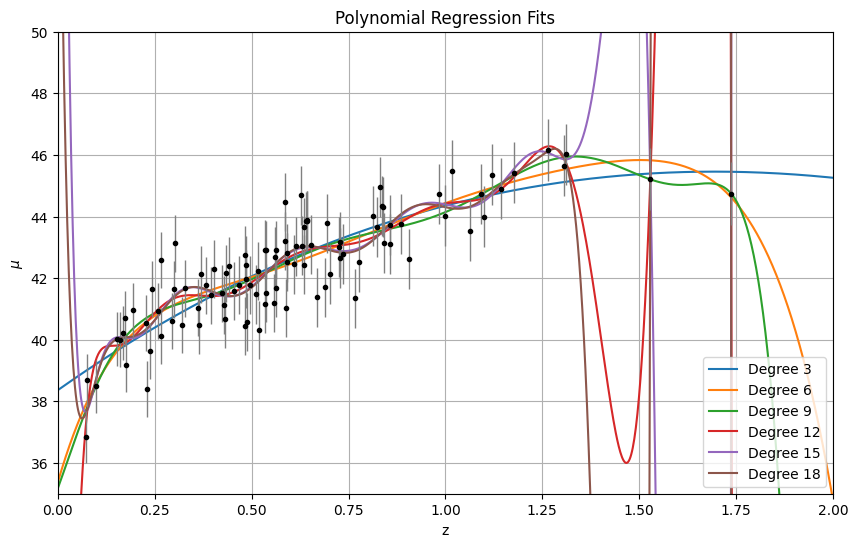

In [90]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline

z = np.linspace(0, 2, 1000)  # Smooth plotting points

aic_list = []
bic_list = []
degrees = np.arange(1, 20)

N = len(mu_sample)
weights = 1 / dmu**2

plt.figure(figsize=(10, 6))
for n in degrees:
    model = Pipeline([
        ('poly', PolynomialFeatures(degree=n)),
        ('linearregression', LinearRegression())
    ])

    model.fit(z_sample[:, np.newaxis], mu_sample, linearregression__sample_weight=weights)

    mu_fit = model.predict(z[:, np.newaxis])
    
    if (n%3==0):
        plt.plot(z, mu_fit, label=f'Degree {n}')

    # Predict on training data for residuals
    mu_pred_sample = model.predict(z_sample[:, np.newaxis])

    # Residual sum of squares (weighted)
    rss = np.sum(weights * (mu_sample - mu_pred_sample)**2)

    # Number of parameters (including intercept)
    # PolynomialFeatures produces: C(degree + 1, degree) features, but simpler is:
    # Using the fitted model's coef_ length for number of parameters (excluding intercept)
    k = model.named_steps['linearregression'].coef_.size + 1  # coef_ excludes intercept, add 1

    # Calculate AIC and BIC
    aic = N * np.log(rss / N) + 2 * k
    bic = N * np.log(rss / N) + k * np.log(N)

    aic_list.append(aic)
    bic_list.append(bic)

plt.errorbar(z_sample, mu_sample, yerr=dmu, fmt='.k', ecolor='gray', lw=1)
plt.xlabel('z')
plt.ylabel(r'$\mu$')
plt.title('Polynomial Regression Fits')
plt.legend(loc='lower right')
plt.xlim(0, 2)
plt.ylim(35, 50)
plt.grid(True)
plt.show()




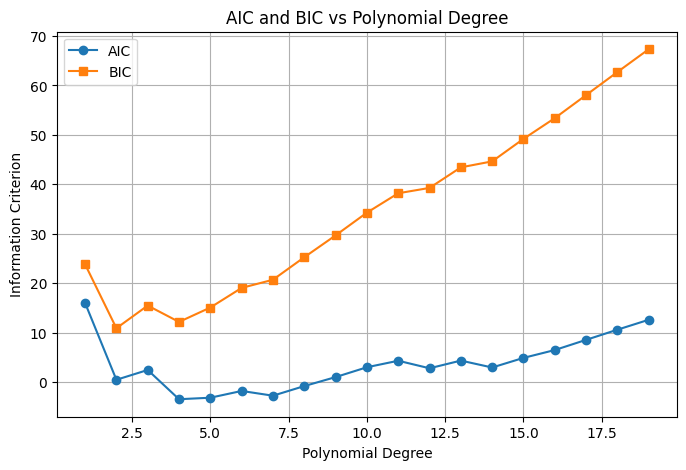

Best polynomial degree according to AIC: 4
Best polynomial degree according to BIC: 2


In [91]:
# Plot AIC and BIC
plt.figure(figsize=(8,5))
plt.plot(degrees, aic_list, label='AIC', marker='o')
plt.plot(degrees, bic_list, label='BIC', marker='s')
plt.xlabel('Polynomial Degree')
plt.ylabel('Information Criterion')
plt.title('AIC and BIC vs Polynomial Degree')
plt.legend()
plt.grid(True)
plt.show()

best_idx = np.argmin(aic_list)
best_degree = degrees[best_idx]
print("Best polynomial degree according to AIC:", best_degree)

best_bic_idx = np.argmin(bic_list)
best_bic_degree = degrees[best_bic_idx]
print("Best polynomial degree according to BIC:", best_bic_degree)


(35.0, 50.0)

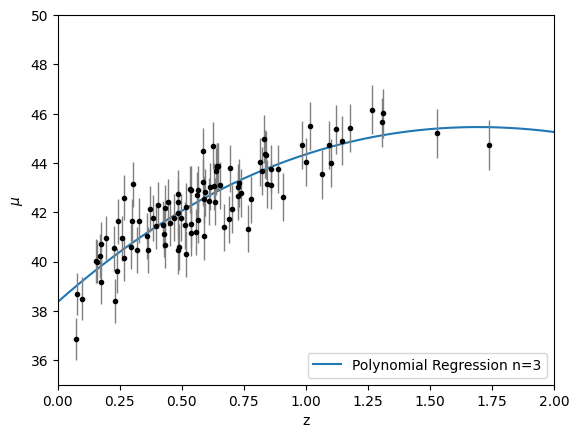

In [92]:
from astroML.linear_model import PolynomialRegression  # WITH ASTROML AGAIN, IS EASIER TO USE

n = 3 #that's maybe the best choice

model = PolynomialRegression(n)
model.fit(z_sample[:,np.newaxis], mu_sample, dmu)
mu_fit = model.predict(z[:,np.newaxis])
plt.plot(z, mu_fit,label='Polynomial Regression n='+str(n))
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1)
plt.xlabel("z")
plt.ylabel(r"$\mu$")
plt.legend(loc='lower right')
plt.xlim(0,2)
plt.ylim(35,50)

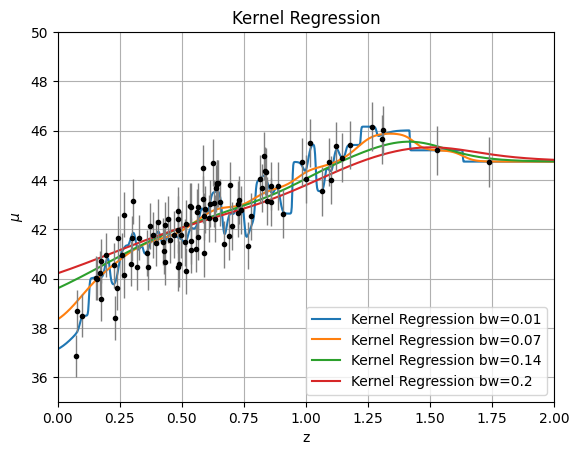

In [93]:
from astroML.linear_model import NadarayaWatson

for bw in np.round(np.linspace(0.01,0.2,4),2):

    regressor = NadarayaWatson('gaussian', bw)

    regressor.fit(z_sample[:,np.newaxis], mu_sample) # in this case dy is irrelevant!
    mu_fit = regressor.predict(z[:,np.newaxis])
   
    mu_fit = regressor.predict(z[:,np.newaxis])
    plt.plot(z, mu_fit,label='Kernel Regression bw='+str(bw))

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1)
plt.xlabel("z")
plt.ylabel(r"$\mu$")
plt.legend(loc='lower right')
plt.xlim(0,2)
plt.ylim(35,50)
plt.grid(True)
plt.title("Kernel Regression")
plt.show()

In [94]:
from sklearn.model_selection import train_test_split

X = z_sample[:,np.newaxis]
y = mu_sample
dy = dmu

X_train, X_validation, y_train, y_validation= train_test_split(X, y, test_size=0.3, random_state=42)
dy_train , dy_validation = train_test_split(dy, test_size=0.3, random_state=42) #same seed

### Kernel regression (Nadaraya-Watson)

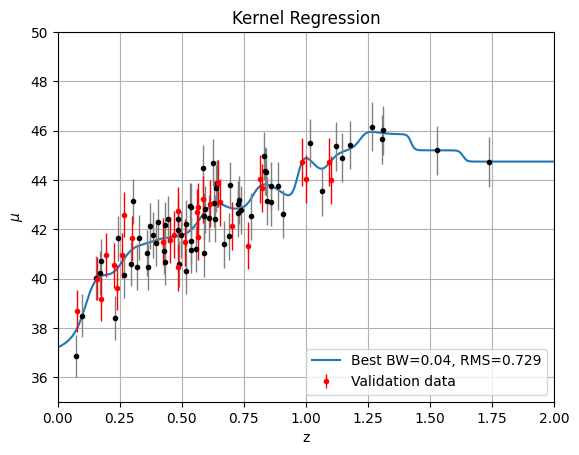

In [95]:
from astroML.linear_model import NadarayaWatson

x_space = np.linspace(0, 2, 1000)

def RMS(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred)**2))

bw_values = np.round(np.linspace(0.01, 1, 30), 2)
val_errors = []

for bw in bw_values:
    regressor = NadarayaWatson('gaussian', bw)
    regressor.fit(X_train, y_train)
    y_val_pred = regressor.predict(X_validation)
    
    error = RMS(y_validation, y_val_pred)
    val_errors.append(error)


best_bw = bw_values[np.argmin(val_errors)]

# Fit again with best bandwidth
regressor = NadarayaWatson('gaussian', best_bw)
regressor.fit(X_train, y_train)
mu_fit = regressor.predict(x_space[:, np.newaxis])
plt.plot(x_space, mu_fit, label=f'Best BW={best_bw}, RMS={min(val_errors):.3f}')
plt.errorbar(X_train, y_train, dy_train, fmt='.k', ecolor='gray', lw=1)
plt.errorbar(X_validation, y_validation, dy_validation, fmt='.r', ecolor='red', lw=1, label='Validation data')
plt.xlabel("z")
plt.ylabel(r"$\mu$")
plt.legend(loc='lower right')
plt.xlim(0,2)
plt.ylim(35,50)
plt.grid(True)
plt.title("Kernel Regression")
plt.show()


### Cross validation

Best 4


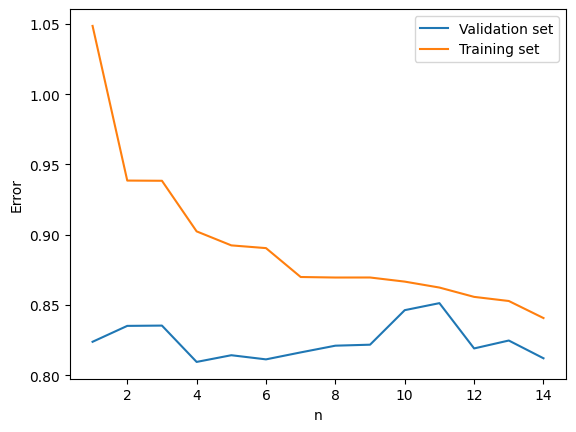

In [96]:
# This method splits the dataset once into training and validation sets. 
# The model is trained on the training data and evaluated on the validation set for different polynomial degrees.
# It is fast and easy to implement but can give unstable results if the split is not representative or the dataset is small.
# It uses less data for training and is less reliable for model selection.


def RMS(X,y,classifier):
    return np.sqrt( np.sum(( y - classifier.predict(X) )**2) / len(X) )

def fitanderror(classifier):
    classifier.fit(X_train, y_train, dy_train)
    error_train = RMS(X_train,y_train,classifier)
    error_validation  = RMS(X_validation, y_validation, classifier)
    return error_train, error_validation

nrange = np.arange(1,15)

err_train, err_test= [], []

for n in nrange:
    model = PolynomialRegression(n)
    error_train, error_validation = fitanderror(model)
    #print("Polynomial Regression n=",n, error_train, error_validation)
    err_train.append(error_train)
    err_test.append(error_validation)

plt.plot(nrange,err_test, label='Validation set')
plt.plot(nrange,err_train, label='Training set')

plt.xlabel('n')
plt.ylabel('Error')
plt.legend()

print("Best", nrange[np.argmin(err_test)])

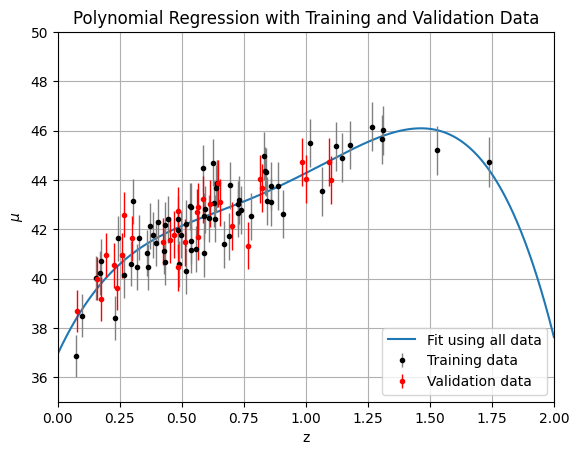

In [97]:
model = PolynomialRegression(4)

model.fit(z_sample[:,np.newaxis], mu_sample,dmu) 
mu_fit = model.predict(z[:,np.newaxis])

plt.plot(z, mu_fit, label='Fit using all data')

plt.errorbar(X_train, y_train, dy_train, fmt='.k', ecolor='gray', lw=1,label='Training data')
plt.errorbar(X_validation, y_validation, dy_validation, fmt='.r', ecolor='red', lw=1, label='Validation data')

plt.xlabel("z")
plt.ylabel(r"$\mu$")
plt.xlim(0,2)
plt.ylim(35,50)
plt.legend(loc='lower right')
plt.grid(True)
plt.title("Polynomial Regression with Training and Validation Data")
plt.show()

Degree 1: Train RMS = 0.987, Validation RMS = 0.781
Degree 2: Train RMS = 0.904, Validation RMS = 0.747
Degree 3: Train RMS = 0.904, Validation RMS = 0.771
Degree 4: Train RMS = 0.871, Validation RMS = 0.756
Degree 5: Train RMS = 0.865, Validation RMS = 0.727
Degree 6: Train RMS = 0.862, Validation RMS = 0.932
Degree 7: Train RMS = 0.849, Validation RMS = 0.737
Degree 8: Train RMS = 0.849, Validation RMS = 1.085


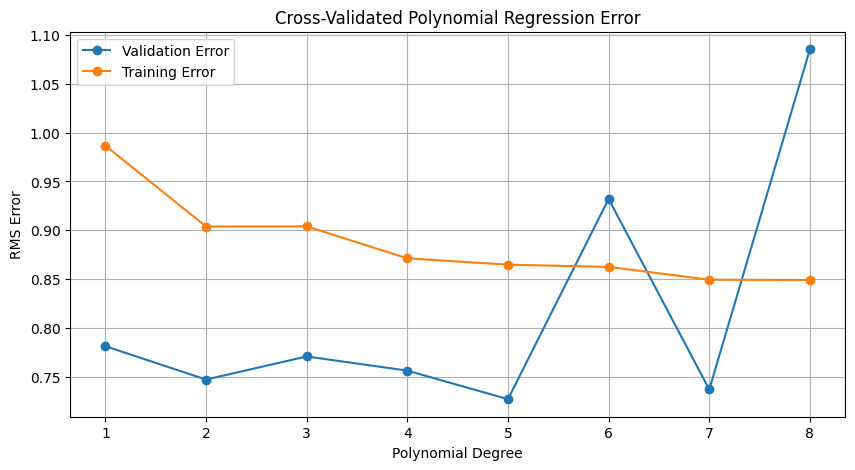


 Best polynomial degree: 5, with RMS = 0.727


In [102]:
# This method partitions the data into K folds and iteratively trains on K-1 folds while validating on the remaining fold. 
# Errors are averaged across folds to give a more robust and reliable estimate of model performance. 
# It is computationally more expensive but better suited for small datasets and reduces dependency on a single data split, 
# providing more stable model selection.

from sklearn.model_selection import KFold

# Polynomial regression factory
def PolynomialRegression(degree):
    return Pipeline([
        ('poly', PolynomialFeatures(degree=degree)),
        ('reg', LinearRegression())
    ])

# K-Fold Cross-Validation
K = len(z_sample) #leave-one-out cross-validation
kf = KFold(n_splits=K, shuffle=True, random_state=42) #kf = LeaveOneOut()

nrange = np.arange(1, 9)
err_train, err_val = [], []

for n in nrange:
    rms_train_folds, rms_val_folds = [], []
    
    for train_index, val_index in kf.split(X):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]
        dy_train = dy[train_index]

        model = PolynomialRegression(n)
        model.fit(X_train, y_train, reg__sample_weight=1/dy_train**2)

        rms_train_folds.append(RMS(X_train, y_train, model))
        rms_val_folds.append(RMS(X_val, y_val, model))

    mean_train = np.mean(rms_train_folds) #this use the mean not only the best
    mean_val = np.mean(rms_val_folds)

    err_train.append(mean_train)
    err_val.append(mean_val)

    print(f"Degree {n}: Train RMS = {mean_train:.3f}, Validation RMS = {mean_val:.3f}")

# Plotting error vs degree
plt.figure(figsize=(10, 5))
plt.plot(nrange, err_val, label="Validation Error", marker='o')
plt.plot(nrange, err_train, label="Training Error", marker='o')
plt.xlabel("Polynomial Degree")
plt.ylabel("RMS Error")
plt.title("Cross-Validated Polynomial Regression Error")
plt.legend()
plt.grid(True)
plt.show()

# Best model degree
best_n = nrange[np.argmin(err_val)]
print(f"\n Best polynomial degree: {best_n}, with RMS = {min(err_val):.3f}")



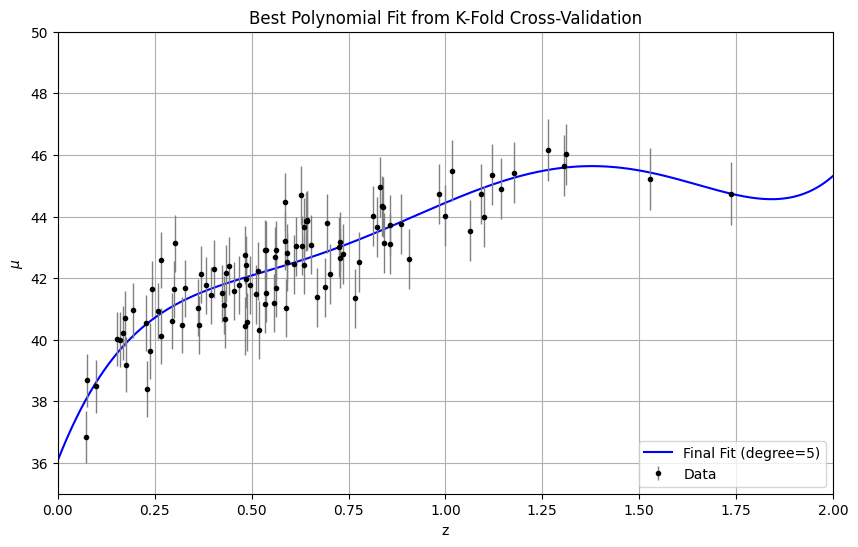

In [99]:
# Final model trained on full data with best degree
model = PolynomialRegression(best_n)
model.fit(X, y, reg__sample_weight=1/dy**2)

z = np.linspace(0, 2, 1000)
mu_fit = model.predict(z[:, np.newaxis])

# Final plot
plt.figure(figsize=(10, 6))
plt.plot(z, mu_fit, label=f'Final Fit (degree={best_n})', color='blue')
plt.errorbar(X[:, 0], y, yerr=dy, fmt='.k', ecolor='gray', lw=1, label='Data')
plt.xlabel("z")
plt.ylabel(r"$\mu$")
plt.xlim(0, 2)
plt.ylim(35, 50)
plt.legend(loc='lower right')
plt.title("Best Polynomial Fit from K-Fold Cross-Validation")
plt.grid(True)
plt.show()